In [182]:
## installs the required packages for the notebook
#!pip install ipympl
#!pip install plotly

In [183]:
# import Python libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import IPython
import wave
import librosa
import plotly.graph_objects as go
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
pd.options.plotting.backend = "matplotlib"
%matplotlib inline
# switch back to make plts just images

# **CW2: DeepFake Voice Recognition**
## **Data set explanation**
### Original Audio Dataset:
- Audio recordings of a 8 well-known public figures
- AI-generated speech via Retrival-based Voice Conversion (RVC)

![test](deepfake_summary.png)

Retrieval-based Voice Conversion (RVC) is a type of voice cloning that uses a database of pre-recorded speech to create a synthetic copy of a person's voice. RVC systems work by finding the pre-recorded speech that is most similar to the input speech, and then converting the input speech to sound like the pre-recorded speech.

In [184]:
real_audio = "trump_original_short.wav"
fake_audio = "trump_to_musk_short.wav"

print("Real audio from Donald Trump:")
IPython.display.Audio(real_audio)

Real audio from Donald Trump:


In [185]:
print("DeepFake audio of Donald Trump -> Elon Musk's voice:")
IPython.display.Audio(fake_audio)

DeepFake audio of Donald Trump -> Elon Musk's voice:


Issues with this:
- Potential for misrepresentation and identity theft
- Scams
- ...

### **Case question**: Can we distinguish RVC-generated speeches from real speeches using machine learning?


The samping rate of the audio file is 48.0kHz
The audio contains a total of 464640 frames or samples
<class 'numpy.ndarray'>


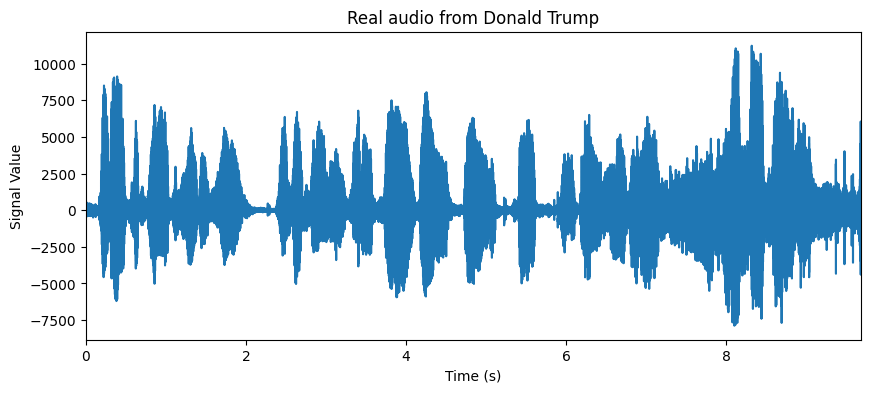

In [186]:
# real audio data collection
trump_original = wave.open('trump_original_short.wav', 'rb')
sample_freq_org = trump_original.getframerate()
n_samples_org = trump_original.getnframes()
t_audio_org = n_samples_org/sample_freq_org
print("The samping rate of the audio file is " + str(sample_freq_org/1000) + "kHz")
print("The audio contains a total of " + str(n_samples_org) + " frames or samples")
signal_wave_org = trump_original.readframes(n_samples_org)
signal_array_org = np.frombuffer(signal_wave_org, dtype=np.int16)
print(type(signal_array_org))

# x-axis for the plots
timestamps_org = np.linspace(0, n_samples_org/sample_freq_org, num=n_samples_org)

plt.figure(figsize=(10, 4))
# first plot
plt.plot(timestamps_org, signal_array_org)
plt.title('Real audio from Donald Trump')
plt.ylabel('Signal Value')
plt.xlabel('Time (s)')
plt.xlim(0, t_audio_org)
plt.show()

464640
48000


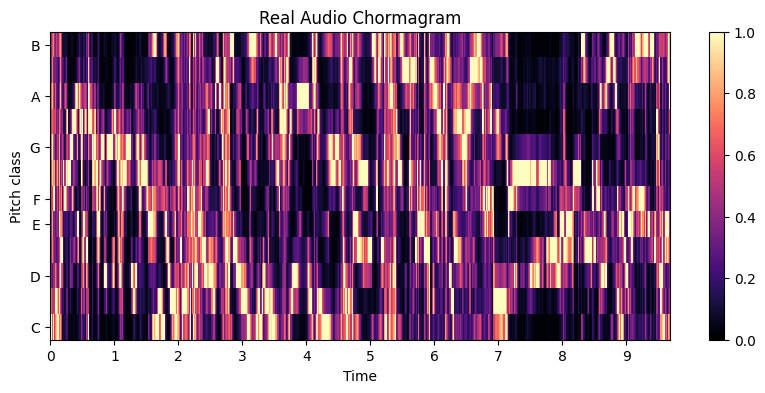

In [187]:
# chromagram
real_ad, real_sr = librosa.load(real_audio, sr = sample_freq_org)
print(len(real_ad))
print(real_sr)
real_chroma = librosa.feature.chroma_stft(y = real_ad, sr = real_sr, n_chroma=12)
# Convert frames to time
time = librosa.frames_to_time(range(real_chroma.shape[1]), sr=real_sr)
plt.figure(figsize = (10, 4))
librosa.display.specshow(real_chroma, sr = real_sr, x_axis = 'time', y_axis = 'chroma', vmin = 0, vmax = 1)
plt.colorbar()
plt.title('Real Audio Chormagram')
plt.show()

Spectogram that captures harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation. (It identify pitches that differ by an octave)

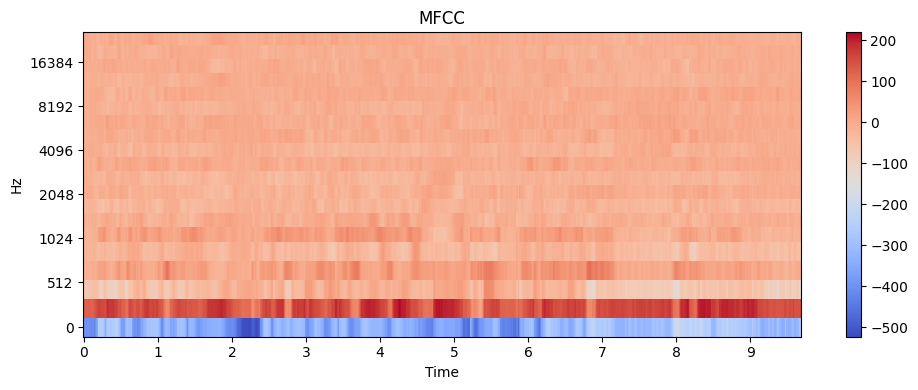

In [188]:
# MFCC
mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr, n_mfcc=20)

# Display MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', y_axis='mel', sr=real_sr)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

Frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound.

### Final Audio FEATURES Dataset:
The dataset has each feature extracted from one-second windows of audio and are balanced through random sampling.


#### Time domain features:
- **Root Mean Square**

- **Zero Crossing Rate ZCR**: Measured by observing the rate at which the signal (containing N samples) changes from positive to negative or vice-versa.

#### Frequency domain features - Chromagram:

- **Chromagram**: Intensity. Not certain if mean or max or other used as there are multiple bands.

- **Spectral Centroid**: Location of the centre of mass in the spectrum.

- **Spectal Bandwidth**: Power-weighted standard deviation of the frequency values from the centroid.

- **Spectral Rolloff**: Frequency at which the cumulated spectral energy reaches 85% of the total spectral energy

#### Frequency domain features - MFCC:
- **First 20 Mel-Frequency Cepstral Coefficients (MFCCs)**: 1 coefficient per frequency band, characterise the shape of the spectral envelope. 

### **ML project objective**:
- Establish different prediction models for RVC-generated speech and rate their effectiveness. 

### **Why this data set**:
- Similar to certain aspects of my individual project

In [189]:
# Load data set
df = pd.read_csv("DATASET-balanced.csv")
df

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,FAKE
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,FAKE
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,FAKE
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,FAKE
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,FAKE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11773,0.435426,0.025303,2772.575031,2728.757601,4998.670213,0.074323,-342.309753,144.490418,-79.272942,8.890874,...,-17.982819,-7.831161,-1.127167,-7.669674,-0.653850,-8.037575,-2.671002,-4.483765,-3.355975,REAL
11774,0.454611,0.070578,1029.274601,1519.231563,1922.927486,0.026553,-332.230408,202.603012,-0.181929,-2.146542,...,-2.018668,-2.705635,-1.589172,-2.938737,-0.972690,-1.706672,-2.796168,2.171270,-1.660128,REAL
11775,0.374432,0.019063,4063.645317,3558.261357,7299.133512,0.110278,-372.149109,92.670235,-29.082432,59.736637,...,-6.628118,-3.827499,-7.287946,-2.899543,-11.508186,-1.296590,-14.325416,-4.405540,-15.869982,REAL
11776,0.410885,0.090499,1124.655596,1553.651133,2065.942806,0.031761,-328.062805,193.557526,6.779151,-1.304731,...,-5.437202,-4.252508,-1.258683,-2.107233,-1.018154,-2.716950,-3.681598,3.811063,3.948419,REAL


## **Data Analysis and preparation**
- Data size
- Data type 
- NaN (missing data)
- Duplicate

In [190]:
df.info()

print("\n\n")
print("shape of data set(row, column): ",df.shape)
print("\n\n")

nan_counts = df.isna().sum()
print("NaN count for every column:\n",nan_counts)

any_duplicates = df.duplicated().any()
# Display the result
if any_duplicates:
    print("\nThere are duplicates in the DataFrame.\n")
else:
    print("\nNo duplicates found in the DataFrame.\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11778 entries, 0 to 11777
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chroma_stft         11778 non-null  float64
 1   rms                 11778 non-null  float64
 2   spectral_centroid   11778 non-null  float64
 3   spectral_bandwidth  11778 non-null  float64
 4   rolloff             11778 non-null  float64
 5   zero_crossing_rate  11778 non-null  float64
 6   mfcc1               11778 non-null  float64
 7   mfcc2               11778 non-null  float64
 8   mfcc3               11778 non-null  float64
 9   mfcc4               11778 non-null  float64
 10  mfcc5               11778 non-null  float64
 11  mfcc6               11778 non-null  float64
 12  mfcc7               11778 non-null  float64
 13  mfcc8               11778 non-null  float64
 14  mfcc9               11778 non-null  float64
 15  mfcc10              11778 non-null  float64
 16  mfcc

### Class representation - Pie Chart

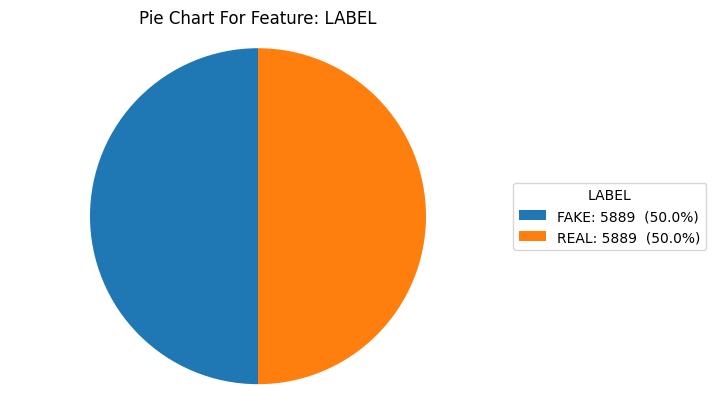

In [191]:
feature_name = 'LABEL'
# Count the occurrences of each unique value in the feature
value_counts = df[feature_name].value_counts()

# Create a pie chart without labels on the pie slices
pie_chart = plt.pie(value_counts, labels=None, startangle=90, autopct='')
# Equal aspect ratio ensures that the pie is drawn as a circle
plt.axis('equal')
# Add legend with category names, percentages, and colors
total_samples = len(df[feature_name])
legend_labels = [f'{label}: {count}  ({count / total_samples * 100:.1f}%)' for label, count in zip(value_counts.index, value_counts)]
plt.legend(pie_chart[0], legend_labels, title=feature_name, bbox_to_anchor=(1, 0.5), loc="center left")
plt.title(f'Pie Chart For Feature: {feature_name}')
dpi = 300
plt.show()

We have a balanced dataset:
- No bias of ML model toward a class if random sampling is conducted.
- Accuracy metric is valid and relevant to use.

## Numerical features representation - Box Plot 

In [192]:
df.describe()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,...,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000,11778.000000
mean,0.421925,0.037894,2719.201373,3050.299988,4977.617722,0.070821,-382.562312,145.056311,-24.699932,21.311292,...,-2.242488,-4.439806,-1.657739,-2.107442,-2.606924,-1.641709,-3.320340,-3.117110,-2.754034,-4.427346
std,0.069392,0.028071,1066.754739,872.258653,2170.158448,0.039292,79.593413,36.188506,27.728976,22.480432,...,7.726415,6.614913,5.121732,5.347953,4.909579,5.627377,4.597079,4.976511,4.957660,5.478806
min,0.200353,0.000043,756.163229,1096.903152,1063.964279,0.015504,-1055.002197,-83.816765,-132.491104,-47.770000,...,-29.636639,-30.168062,-19.717999,-21.553347,-28.876045,-20.307486,-22.753056,-19.623880,-23.890470,-25.099829
25%,0.372330,0.015098,2062.875836,2569.289971,3448.144178,0.045749,-432.928848,120.522711,-35.550402,3.635681,...,-6.863236,-8.233070,-5.178427,-5.642066,-5.760252,-4.868709,-6.435052,-5.862841,-5.514250,-7.463774
50%,0.417708,0.031870,2579.963841,3055.863462,4683.958018,0.060237,-365.756241,145.970162,-19.164229,22.218458,...,-2.438328,-4.186015,-1.530670,-2.320350,-2.447045,-0.862829,-3.230387,-2.957088,-2.726495,-3.839427
75%,0.467741,0.054046,3283.857559,3581.271953,6211.301553,0.085149,-321.772781,168.321331,-6.235028,37.017731,...,2.349474,-0.266044,1.794835,1.569430,0.837690,2.043472,-0.293191,0.068411,0.495779,-0.787292
max,0.707202,0.168958,17685.006690,7836.844404,21130.544670,0.812480,-193.430145,284.727997,67.475792,86.585747,...,28.890339,22.552883,19.462509,21.356049,13.319826,19.329521,18.873386,17.924467,11.985058,11.764109


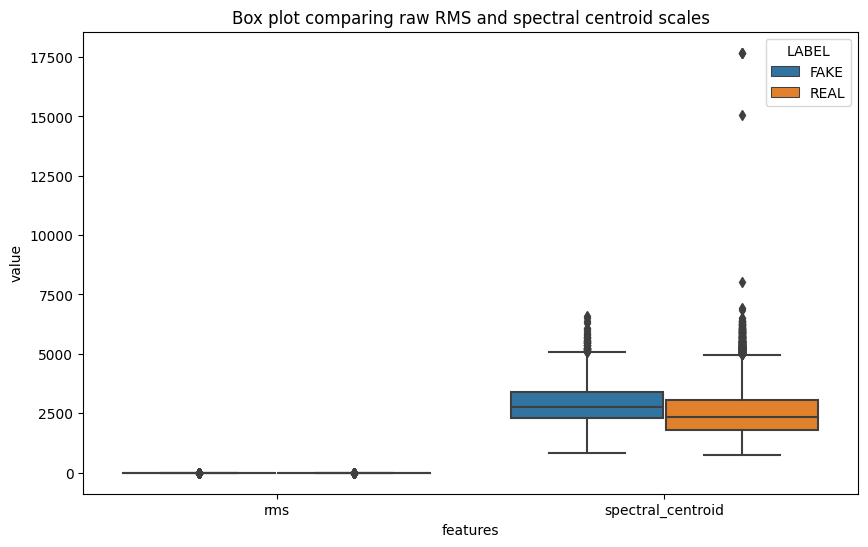

In [193]:
# Select only the necessary columns and melt the DataFrame
melted_df = pd.melt(df[['rms', 'spectral_centroid', 'LABEL']], "LABEL", var_name="features")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="features", y="value", hue="LABEL", data=melted_df)
plt.title('Box plot comparing raw RMS and spectral centroid scales')
# Show the plot
plt.show()

Featues with different scales:
- Can significantly impact the perfomance of ML algorithms that are sensitive to this issue such as SVMs
- Slow down the convergence speed of ML algorithms
- Standardisation or normalisation

## Data optimisation
Data standardization: Gaussian with zero mean and unit variance.


In [194]:
scaler = StandardScaler()
df_std = df.drop(columns=['LABEL'])
df_std = scaler.fit_transform(df_std) # will remove featue name row
df_std = pd.DataFrame(df_std, columns=df.columns[:-1]) # put back feature name row
df_std['LABEL'] = df['LABEL'] # put back LABEL row
df_std.describe()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,1.177800e+04,1.177800e+04,1.177800e+04,1.177800e+04,1.177800e+04,1.177800e+04,1.177800e+04,1.177800e+04,1.177800e+04,1.177800e+04,...,1.177800e+04,1.177800e+04,1.177800e+04,1.177800e+04,1.177800e+04,1.177800e+04,1.177800e+04,11778.000000,11778.000000,1.177800e+04
mean,2.123544e-16,9.652474e-17,-1.351346e-16,-2.895742e-17,-6.756732e-17,2.413118e-16,3.330103e-16,-9.652474e-17,-1.351346e-16,2.895742e-17,...,3.378366e-17,5.791484e-17,9.652474e-18,1.447871e-17,-9.652474e-18,-2.895742e-17,-7.239355e-17,0.000000,0.000000,-1.689183e-17
std,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,...,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042,1.000042,1.000042e+00
min,-3.193205e+00,-1.348453e+00,-1.840274e+00,-2.239565e+00,-1.803472e+00,-1.407880e+00,-8.448795e+00,-6.324737e+00,-3.887477e+00,-3.073083e+00,...,-3.545670e+00,-3.889597e+00,-3.526352e+00,-3.636294e+00,-5.350812e+00,-3.317100e+00,-4.227367e+00,-3.317077,-4.263570,-3.773333e+00
25%,-7.147493e-01,-8.121251e-01,-6.152805e-01,-5.514768e-01,-7.048050e-01,-6.381008e-01,-6.328247e-01,-6.779678e-01,-3.913210e-01,-7.862999e-01,...,-5.980710e-01,-5.734657e-01,-6.874309e-01,-6.609583e-01,-6.423081e-01,-5.734708e-01,-6.775705e-01,-0.551762,-0.556781,-5.542369e-01
50%,-6.078441e-02,-2.145929e-01,-1.305300e-01,6.378509e-03,-1.353229e-01,-2.693694e-01,2.111580e-01,2.525359e-02,1.996445e-01,4.035529e-02,...,-2.534789e-02,3.836804e-02,2.481097e-02,-3.981288e-02,3.256608e-02,1.384149e-01,1.956814e-02,0.032157,0.005555,1.073125e-01
75%,6.602736e-01,5.754044e-01,5.293439e-01,6.087581e-01,5.685005e-01,3.646849e-01,7.637832e-01,6.429115e-01,6.659348e-01,6.987012e-01,...,5.943451e-01,6.309893e-01,6.741316e-01,6.875580e-01,7.016407e-01,6.548945e-01,6.585220e-01,0.640139,0.655541,6.644164e-01
max,4.111287e+00,4.669174e+00,1.402988e+01,5.487762e+00,7.443518e+00,1.887616e+01,2.376330e+00,3.859723e+00,3.324307e+00,2.903735e+00,...,4.029573e+00,4.080754e+00,4.123829e+00,4.387564e+00,3.244153e+00,3.726802e+00,4.827994e+00,4.228358,2.973120,2.955414e+00


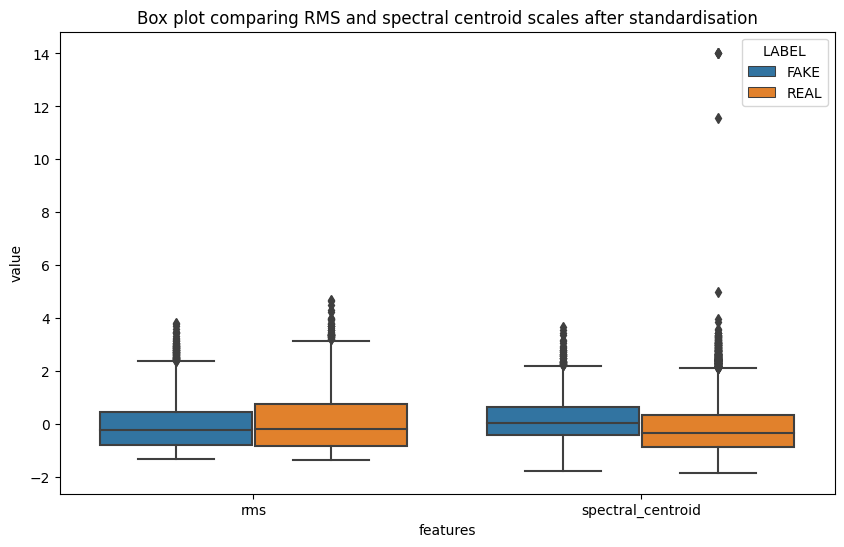

In [195]:
# Select only the necessary columns and melt the DataFrame
melted_df = pd.melt(df_std[['rms', 'spectral_centroid', 'LABEL']], "LABEL", var_name="features")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="features", y="value", hue="LABEL", data=melted_df)
plt.title('Box plot comparing RMS and spectral centroid scales after standardisation')
# Show the plot
plt.show()

### Label encoding
Encoding the 'LABEL' feature from categorical data to numerical (binary here) to enable its use by ML algorithms

In [196]:
le_type = LabelEncoder()
## raw data encoding
df_enc = df.copy()
df_enc['LABEL'] = le_type.fit_transform(df_enc['LABEL'])
## stdized data encoding
df_std_enc = df_std.copy()
df_std_enc['LABEL'] = le_type.fit_transform(df_std_enc['LABEL'])
# Print the labels and their corresponding integer values
for i, label in enumerate(le_type.classes_):
    print(f"{label} = {i}")

df_std_enc.iloc[:,-4:]

FAKE = 0
REAL = 1


,mfcc18,mfcc19,mfcc20,LABEL
0,0.818087,-0.455699,-0.429257,0
1,0.273190,-1.368420,-0.742360,0
2,0.301427,-0.235670,-0.475608,0
3,-0.460172,-0.181725,0.210363,0
4,1.152252,0.193785,-0.115660,0
...,...,...,...,...
11773,0.089647,-0.348915,0.195557,1
11774,0.064494,0.993516,0.505098,1
11775,-2.252338,-0.333136,-2.088616,1
11776,-0.113435,1.324289,1.528822,1


### Feature importance - Correlation matrix

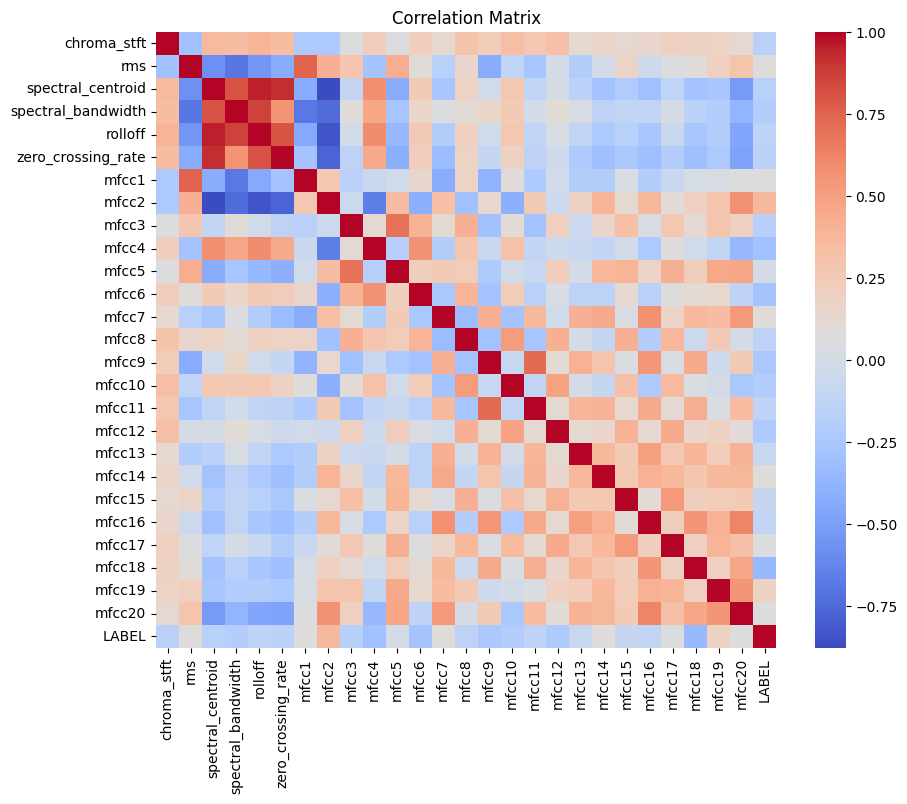

In [197]:
# assess the correlation between the features
correlation_matrix = df_enc.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [198]:
correlation_df = pd.DataFrame(columns=['Feature', 'Correlation', 'corr_score'])

# Calculate the correlation
for feature in df_enc.columns:
    if feature != 'LABEL':
        correlation = df_enc['LABEL'].corr(df_enc[feature])
        correlation = round(np.abs(correlation), 2) #abs to be able to sort in descending order later


        # Append the feature name and correlation to the DataFrame
        correlation_df = correlation_df.append({'Feature': feature,
                                                'Correlation': correlation}, ignore_index=True)

# Sort correlation_df in descending order based on the 'Correlation' column
correlation_df = correlation_df.sort_values('Correlation', ascending=False)
# Go through the list from the first to the last row and input a value in corr_score and total score
for i, row in enumerate(correlation_df.itertuples()):
    
    corr_scr = 25 - i
    correlation_df.loc[row.Index, 'corr_score'] = corr_scr


correlation_df

,Feature,Correlation,corr_score
7,mfcc2,0.36,25.0
23,mfcc18,0.35,24.0
9,mfcc4,0.30,23.0
11,mfcc6,0.28,22.0
14,mfcc9,0.24,21.0
17,mfcc12,0.22,20.0
15,mfcc10,0.21,19.0
3,spectral_bandwidth,0.19,18.0
24,mfcc19,0.19,17.0
8,mfcc3,0.18,16.0


## Pair-plots

In [199]:
# # Create a new DataFrame with the first 5 columns and the 'LABEL' column
# df3 = df_enc.iloc[:, :5].copy()
# df3['LABEL'] = df_enc['LABEL']

# sns.pairplot(df_enc, hue='LABEL')

In [200]:
# # Create a new DataFrame with the first 5 columns and the 'LABEL' column
# df4 = df_enc.iloc[:, 5:10].copy()
# df4['LABEL'] = df_enc['LABEL']

# sns.pairplot(df4, hue='LABEL')

In [201]:
# # Create a new DataFrame with the first 5 columns and the 'LABEL' column
# df5 = df_enc.iloc[:, 11:15].copy()
# df5['LABEL'] = df_enc['LABEL']

# sns.pairplot(df5, hue='LABEL')

In [202]:
# # Create a new DataFrame with the first 5 columns and the 'LABEL' column
# df6 = df_enc.iloc[:, 16:20].copy()
# df6['LABEL'] = df_enc['LABEL']

# sns.pairplot(df6, hue='LABEL')

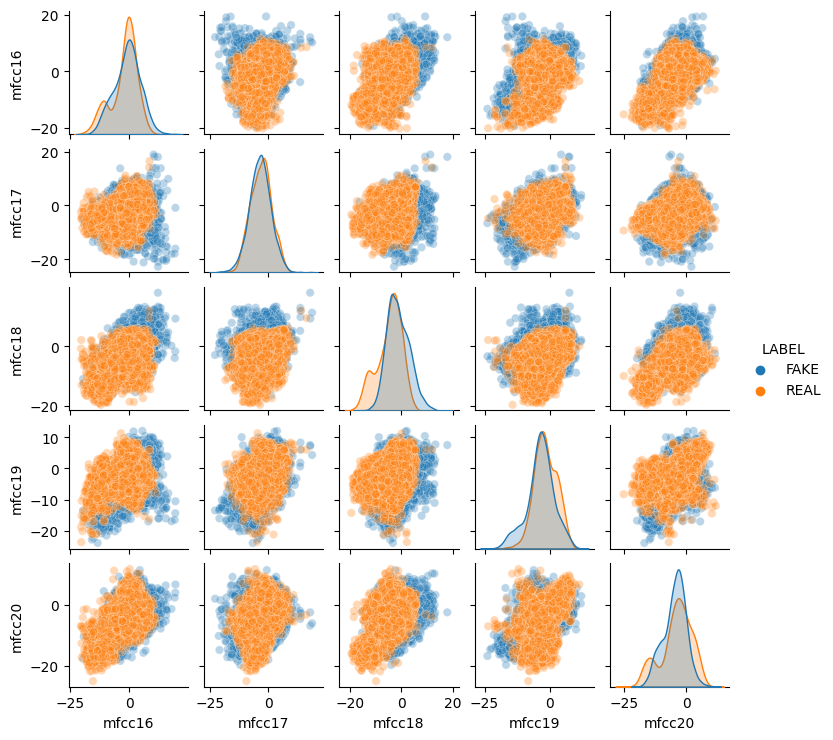

In [203]:
# Create a new DataFrame with the first 5 columns and the 'LABEL' column
df7 = df.iloc[:, 21:28].copy()
df7['LABEL'] = df['LABEL']
# Convert the 'LABEL' column to a categorical type
df7['LABEL'] = df7['LABEL'].astype('category')
#plt.figure(figsize=(5, 3))
sns.pairplot(df7,hue='LABEL', plot_kws={'alpha': 0.3}, height=1.5)

### 3D visualisation of high correlation features
HTML method (outside notebook)

In [204]:
# Create a color map for the unique classes
classes = df['LABEL'].unique()
colors = px.colors.qualitative.Plotly  # A list of colors
colormap = {c: colors[i % len(colors)] for i, c in enumerate(classes)}

imp3feat = correlation_df['Feature'].head(3)
imp3feat.index = range(1, len(imp3feat) + 1) # re-indexing from 1 to 3

# Create a trace for each class
traces = []
for c in classes:
    subset = df[df['LABEL'] == c] #change dataset here depending on std or raw df
    trace = go.Scatter3d(
        x=subset[imp3feat[1]],
        y=subset[imp3feat[2]],
        z=subset[imp3feat[3]],
        mode='markers',
        marker=dict(color=colormap[c]),
        name=str(c)
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    scene=dict(
        xaxis_title=imp3feat[1],
        yaxis_title=imp3feat[2],
        zaxis_title=imp3feat[3]
    )
)

# Create the figure and add the traces
fig = go.Figure(data=traces, layout=layout)

# Save the figure as an HTML file
fig.write_html('3d_scatter_plot.html')

## **Model selection and training**
#### Models Selected (Supervised learning/Classification):
1. Decision Tree 
2. SVM/SVC
3. Ensemble - Random forest
4. Artificial Neural Network - Single layer perceptron 
5. Ensemble - Random forest + SVC_rbf + SVC_poly + SVC_linear + perceptron

<br><br>

#### Data split and data frame for results:

Data split: train = 80% / validate = 10% (model hyperparameters tuned on this) / test = 10%

In [205]:
# Data split    
x=df_std_enc.iloc[:,:26]
y=df_std_enc['LABEL']

test_ratio =0.1
train_ratio = 0.8/0.9
val_ratio = 0.1/0.9
rdm_val = 78

# Split the data into training+validation set and test set 
x_trval, x_test, y_trval, y_test = train_test_split(x, y, test_size=test_ratio, random_state=rdm_val)

# Split the training+validation set into training and validation sets 
x_train, x_val, y_train, y_val = train_test_split(x_trval, y_trval, test_size=val_ratio, random_state=rdm_val)

# Check the distribution of classes in the training, validation, and test sets
print("data distribution in each split:")
print("\nx_train: ", len(x_train))
print(y_train.value_counts(normalize=True))
print("\nx_val: ", len(x_val))
print(y_val.value_counts(normalize=True))
print("\nx_test: ", len(x_test))
print(y_test.value_counts(normalize=True))

data distribution in each split:

x_train:  9422
1    0.502653
0    0.497347
Name: LABEL, dtype: float64

x_val:  1178
0    0.500849
1    0.499151
Name: LABEL, dtype: float64

x_test:  1178
0    0.520374
1    0.479626
Name: LABEL, dtype: float64


In [206]:
# Initialize an empty DataFrame for resulst record of ML models
results_df = pd.DataFrame(columns=['Model', 'Parameter', 'Accuracy', 'F1 Score'])
results_df

,Model,Parameter,Accuracy,F1 Score


### 1. Decision tree:

**Pros:** Simple to use / Intuitive and easy to understand / Can generate feature importance.<br>
**Cons:** High variance can cause instability (ie. small changes in input data = can result in different tree structures) / Prone to overfitting.

In [207]:
tree_clf = DecisionTreeClassifier(random_state=rdm_val)
# If random_state is not specified, then each time you run your code,
# a different decision tree will be generated even if the data remains the same. 
# This is because the algorithm involves some randomness in the selection of 
# the feature indices for the best split.
tree_clf.fit(x_train, y_train)

# Calculate the accuracy of the model on the test data
accuracy_val = tree_clf.score(x_val, y_val)
# Print the accuracy validation
print(f"Validation accuracy = {accuracy_val}")

# Add the model name to the first row
results_df.loc[0, 'Model'] = 'Decision Tree'

Validation accuracy = 0.9490662139219015


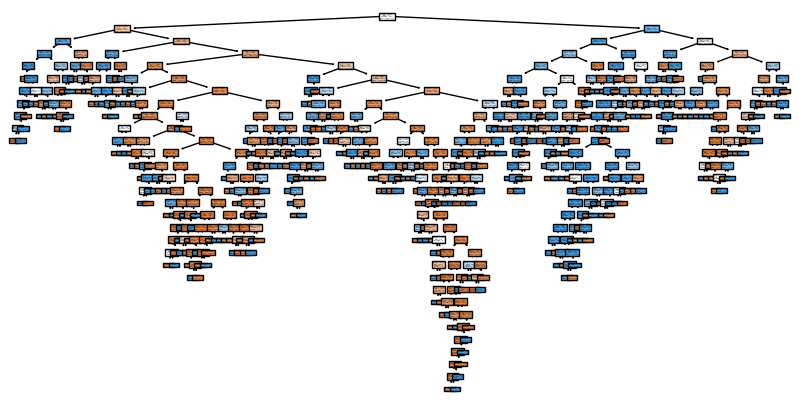

In [208]:
from sklearn import tree

plt.figure(figsize=(10,5))
tree.plot_tree(tree_clf, filled=True)
plt.show()

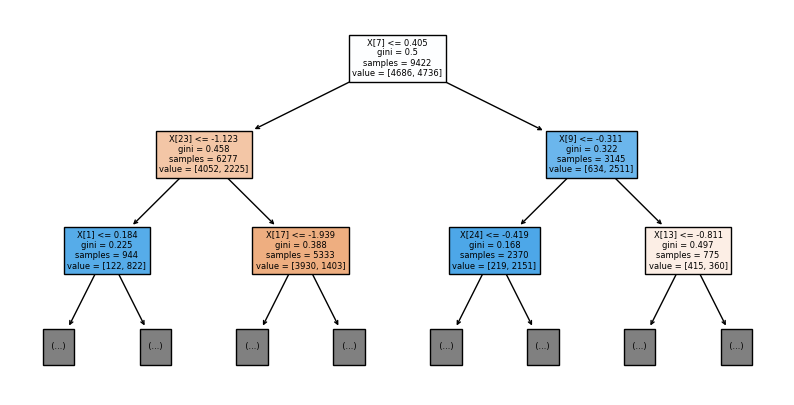

In [209]:
plt.figure(figsize=(10,5))
tree.plot_tree(tree_clf, filled=True, max_depth=2)
plt.show()

Feature Importance

In [210]:
# Initialize an empty DataFrame
fimportance_df = pd.DataFrame(columns=['Feature', 'TreeF_imp', 'TreeF_imp_score'])
feature_names = x.columns
# Calculate feature importances
importances = tree_clf.feature_importances_
# Print feature importances
for feature, importance in zip(feature_names, importances):
    fimportance_df = fimportance_df.append({'Feature': feature, 'TreeF_imp': importance}, ignore_index=True)


# Sort correlation_df in descending order based on the 'Correlation' column
fimportance_df = fimportance_df.sort_values('TreeF_imp', ascending=False)

for i, row in enumerate(fimportance_df.itertuples()):
    
    fimp_tree = 25 - i
    fimportance_df.loc[row.Index, 'TreeF_imp_score'] = fimp_tree

In [211]:
from IPython.display import display, HTML

# Assuming that dataframes df1 and df2 are already defined, here's how to render them side by side
df1_styled = fimportance_df.style.set_table_attributes("style='display:inline'").set_caption('Tree Feature Importance')
df2_styled = correlation_df.style.set_table_attributes("style='display:inline'").set_caption('Correlation')

display(HTML(df1_styled._repr_html_() + "\xa0\xa0\xa0" + df2_styled._repr_html_()))

,Feature,TreeF_imp,TreeF_imp_score
7,mfcc2,0.219110,25.000000
23,mfcc18,0.143811,24.000000
17,mfcc12,0.091755,23.000000
6,mfcc1,0.079221,22.000000
9,mfcc4,0.057865,21.000000
1,rms,0.057616,20.000000
13,mfcc8,0.047427,19.000000
14,mfcc9,0.042147,18.000000
22,mfcc17,0.034140,17.000000
15,mfcc10,0.029909,16.000000


### 2. SVM
**Pros:** Popular and proven competence with audio features (genre classification...) / Good with high dimension<br>
**Cons:** Sensitive to outliers / Data preparation (standardisation) / Parameters optimisation

2.1 Linear SVC

In [212]:
from sklearn.svm import LinearSVC

# Create a LinearSVC model
linear_svc = LinearSVC(C=1, loss="hinge", random_state=rdm_val, max_iter=100000)
# max_iter value increased until no more warning about model did not converge to find the optimal solution
# C high = smaller margin = fewer nb of margin violation
# C was chosen by trial and error
# same for loss= hinge, has better results than squared_hinge

linear_svc.fit(x_train, y_train)

# Calculate the accuracy of the model on the test data
accuracy_svc = linear_svc.score(x_val, y_val)
print(f"Validation accuracy: {accuracy_svc}")
# Append a new row to results_df
results_df.loc[1, 'Model'] = 'Linear SVC'
results_df.loc[1, 'Parameter'] = 'C=1, loss=hinge'
results_df

Validation accuracy: 0.9142614601018676


,Model,Parameter,Accuracy,F1 Score
0,Decision Tree,NaN,NaN,NaN
1,Linear SVC,"C=1, loss=hinge",NaN,NaN


2.2 SVC polynomial kernel

In [213]:
# finding optimal parameters for SVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [214]:
# WARNING: BEST COEFFICIENTS CALCULATION FOR SVC TAKES LONG
## Grid calculation for SVC "poly" kernel
# Define the model
svc = SVC(kernel="poly", max_iter=100000)

# Define the parameter range for 'C', 'degree' and 'coef0'
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'degree': [2, 3, 4, 5],
    'coef0': [0.0, 0.1, 0.5, 1.0]
}

# Run grid search
grid_search = GridSearchCV(svc, param_grid, cv=5)
grid_search.fit(x_train, y_train)
# Print the optimal 'C' value
best_params_poly = grid_search.best_params_
print("Best parameters: ", best_params_poly)

c:\Users\abdel\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning:

Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

c:\Users\abdel\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning:

Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

c:\Users\abdel\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning:

Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



Best parameters:  {'C': 1, 'coef0': 0.5, 'degree': 4}


In [215]:
svc_poly = SVC(kernel="poly", max_iter=100000,
                        C=best_params_poly['C'], 
                        degree=best_params_poly['degree'],
                        coef0=best_params_poly['coef0'], probability=True)
svc_poly.fit(x_train, y_train)

# Calculate the accuracy of the model on the test data
accuracy_svc_poly = svc_poly.score(x_val, y_val)
print(f"Validation accuracy: {accuracy_svc_poly}")
# Append a new row to results_df
results_df.loc[2, 'Model'] = 'SVC Poly'
results_df.loc[2, 'Parameter'] = str(best_params_poly)
results_df

Validation accuracy: 0.9957555178268251


,Model,Parameter,Accuracy,F1 Score
0,Decision Tree,NaN,NaN,NaN
1,Linear SVC,"C=1, loss=hinge",NaN,NaN
2,SVC Poly,"{'C': 1, 'coef0': 0.5, 'degree': 4}",NaN,NaN


#### Others tests done with SVC "poly" (Not seen in notebook)

No scaling:
- best parameters: {'C': 1, 'coef0': 1.0, 'degree': 4}
- Validation accuracy: 0.8315789473684211

MinMax Scaling:
- best parameters: {'C': 0.01, 'coef0': 1.0, 'degree': 5}
- Validation accuracy: 0.9908319185059423


2.3 SVC RBF kernel (Radial Basis Function)

In [216]:
# WARNING: BEST COEFFICIENTS CALCULATION FOR SVC TAKES LONG
svc = SVC(kernel="rbf", max_iter=100000)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.1, 1, 5, 10, 50],
}

# Run grid search
grid_search = GridSearchCV(svc, param_grid, cv=5)
grid_search.fit(x_train, y_train)
best_params_rbf = grid_search.best_params_
print("Best parameters: ", best_params_rbf)

Best parameters:  {'C': 10, 'gamma': 0.1}


In [217]:
svc_rbf = SVC(kernel="rbf", max_iter=100000, **best_params_rbf, probability=True)
svc_rbf.fit(x_train, y_train)

# Calculate the accuracy of the model on the test data
accuracy_svc = svc_rbf.score(x_val, y_val)
print(f"Accuracy: {accuracy_svc}")
# Append a new row to results_df
results_df.loc[3, 'Model'] = 'SVC rbf'
results_df.loc[3, 'Parameter'] = str(best_params_rbf)
results_df

Accuracy: 0.9966044142614601


,Model,Parameter,Accuracy,F1 Score
0,Decision Tree,NaN,NaN,NaN
1,Linear SVC,"C=1, loss=hinge",NaN,NaN
2,SVC Poly,"{'C': 1, 'coef0': 0.5, 'degree': 4}",NaN,NaN
3,SVC rbf,"{'C': 10, 'gamma': 0.1}",NaN,NaN


### 3. Ensemble model - Random Forest

**Pros:** Often more accurate in prediction and feature importance (than single decision tree) / More robust to noise. <br>
**Cons:** More complex = more computationally intensive / "black box" model.

Number of trees calculation

In [218]:
## WARNING: BEST COEFFICIENTS CALCULATION FOR SVC TAKES LONG
from sklearn.ensemble import RandomForestClassifier
accuracy_rf_clf = []
# Initialize the Random Forest Classifier
for i in range(1, 100):
    rf_clf = RandomForestClassifier(n_estimators=i, random_state=rdm_val)

    # Assuming X_train and y_train are your data
    rf_clf.fit(x_train, y_train)

    # Calculate the accuracy of the model on the test data
    accuracy_rf_clf.append(rf_clf.score(x_val, y_val))

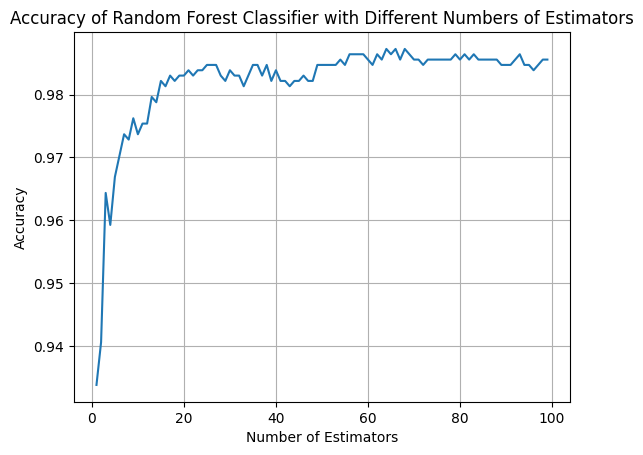

In [219]:
# Plot the accuracies
plt.figure()
plt.plot(range(1, 100), accuracy_rf_clf)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy of Random Forest Classifier with Different Numbers of Estimators')
plt.grid()
plt.show()

In [220]:
# taking the best estimator nb
max_accuracy = max(accuracy_rf_clf)
best_estm = accuracy_rf_clf.index(max_accuracy) + 1

print(f"Maximum accuracy: {max_accuracy} with {best_estm} estimators")

Maximum accuracy: 0.9872665534804754 with 64 estimators


In [221]:
## WARINING: GRID SEARCH FOR RF TAKES LONG
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the classifier
clf_rf = RandomForestClassifier(n_estimators=best_estm, random_state=rdm_val)
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=3, n_jobs=1)

# Fit the GridSearchCV
grid_search.fit(x_train, y_train)

# Get the best parameters
best_params_RF = grid_search.best_params_
print("best parameters:", best_params_RF)

best parameters: {'bootstrap': False, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5}


In [222]:
# Append a new row to results_df
results_df.loc[4, 'Model'] = 'Random Forest'
results_df.loc[4, 'Parameter'] = 'n_est=' + str(best_estm) + ' ' + str(best_params_RF)
results_df

# Initialize the Random Forest Classifier with the best parameters
clf_rf_best = RandomForestClassifier(n_estimators=best_estm, random_state=rdm_val, **best_params_RF)
clf_rf_best.fit(x_train, y_train)
# Calculate the accuracy of the model on the test data
accuracy_rf = clf_rf_best.score(x_val, y_val)
print(f"Validation accuracy: {accuracy_rf}")
##issue here don't have the same accuracy as when doing gridSearch check later


Validation accuracy: 0.9864176570458404


Feature importance

In [223]:
#feature importance check
fimportance_rf_df = pd.DataFrame(columns=['Feature', 'Forest_imp', 'Forest_imp_score'])

# features
feature_names2 = x.columns

# Calculate feature importances
importances2 = clf_rf_best.feature_importances_

# Print feature importances
for feature, importance in zip(feature_names2, importances2):
    fimportance_rf_df = fimportance_rf_df.append({'Feature': feature, 'Forest_imp': importance}, ignore_index=True)

# Sort correlation_df in descending order based on the 'Correlation' column
fimportance_rf_df = fimportance_rf_df.sort_values('Forest_imp', ascending=False)

for i, row in enumerate(fimportance_rf_df.itertuples()):
    
    fimp_forest = 25 - i
    fimportance_rf_df.loc[row.Index, 'Forest_imp_score'] = fimp_forest

In [224]:
# Assuming that dataframes df1 and df2 are already defined, here's how to render them side by side
df1_styled = correlation_df.style.set_table_attributes("style='display:inline'").set_caption('Correlation')
df2_styled = fimportance_df.style.set_table_attributes("style='display:inline'").set_caption('Tree Feature Importance')
df3_styled = fimportance_rf_df.style.set_table_attributes("style='display:inline'").set_caption('Forest Feature Importance')

display(HTML(df1_styled._repr_html_() + "\xa0\xa0\xa0" + df2_styled._repr_html_() + "\xa0\xa0\xa0" + df3_styled._repr_html_()))

,Feature,Correlation,corr_score
7,mfcc2,0.360000,25.000000
23,mfcc18,0.350000,24.000000
9,mfcc4,0.300000,23.000000
11,mfcc6,0.280000,22.000000
14,mfcc9,0.240000,21.000000
17,mfcc12,0.220000,20.000000
15,mfcc10,0.210000,19.000000
3,spectral_bandwidth,0.190000,18.000000
24,mfcc19,0.190000,17.000000
8,mfcc3,0.180000,16.000000


### 4. Perceptron ANN

**Pros:** Can manage high-dimensional data and complex datasets.       <br>
**Cons:** Cannot learn to classify non-linearly separable patterns / "black box" model / Prone to overfitting and noise.

In [225]:
from sklearn.linear_model import Perceptron
# Hyperparameter Tuning
param_grid = {'max_iter': [5000, 10000, 20000], 'tol': [1e-3, 1e-4, 1e-5]}
grid_search = GridSearchCV(Perceptron(random_state=rdm_val), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_params_per = grid_search.best_params_
# Print the best parameters and the best score
print(f"Best parameters: {best_params_per}")

Best parameters: {'max_iter': 5000, 'tol': 0.0001}


In [226]:
per_clf = Perceptron(**best_params_per, random_state=rdm_val)
per_clf.fit(x_train, y_train)

accuracy_per = per_clf.score(x_val, y_val)
print(f"Validation accuracy: {accuracy_per}")

results_df.loc[5, 'Model'] = 'Perceptron'
results_df.loc[5, 'Parameter'] = str(best_params_per)

Validation accuracy: 0.8828522920203735


### 5. Ensemble - Random forest + SVC_rbf + SVC_poly + SVC_linear + perceptron

**Pros:** Different models used to improve the accuracy as they will make different types of errors.   <br>
**Cons:** More complex = more computationally intensive / "black box" model / Individual model parameter tuning.

In [227]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('rf', clf_rf_best),
                ('svc', svc_rbf),
                ('svc_poly', svc_poly),
                ('svc_linear', linear_svc), 
                ('perceptron', per_clf)],
    voting='hard' # hard because'LinearSVC' object has no attribute 'predict_proba'
)
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     min_samples_split=5,
                                                     n_estimators=64,
                                                     random_state=78)),
                             ('svc',
                              SVC(C=10, gamma=0.1, max_iter=100000,
                                  probability=True)),
                             ('svc_poly',
                              SVC(C=1, coef0=0.5, degree=4, kernel='poly',
                                  max_iter=100000, probability=True)),
                             ('svc_linear',
                              LinearSVC(C=1, loss='hinge', max_iter=100000,
                                        random_state=78)),
                             ('perceptron',
                              Perceptron(max_iter=5000, random_state=78,
                                   

In [228]:
for clf in (clf_rf_best, svc_rbf, svc_poly, linear_svc, per_clf, voting_clf):
    #clf.fit(x_train, y_train)
    accuracy2 = clf.score(x_val, y_val)
    print(clf.__class__.__name__, accuracy2)

results_df.loc[6, 'Model'] = 'Ensemble'

RandomForestClassifier 0.9864176570458404
SVC 0.9966044142614601
SVC 0.9957555178268251
LinearSVC 0.9142614601018676
Perceptron 0.8828522920203735
VotingClassifier 0.9906621392190152


## **Results and Analysis**

Testing accuracy of all models

In [229]:
from sklearn.metrics import accuracy_score
# Assuming models is a list of your trained models
models = [tree_clf, linear_svc, svc_poly, svc_rbf, clf_rf_best, per_clf, voting_clf]

for i, model in enumerate(models):
    # Predict the test data
    y_pred = model.predict(x_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    results_df.loc[i, 'Accuracy'] = accuracy

results_df

,Model,Parameter,Accuracy,F1 Score
0,Decision Tree,NaN,0.938879,NaN
1,Linear SVC,"C=1, loss=hinge",0.901528,NaN
2,SVC Poly,"{'C': 1, 'coef0': 0.5, 'degree': 4}",0.993209,NaN
3,SVC rbf,"{'C': 10, 'gamma': 0.1}",0.996604,NaN
4,Random Forest,"n_est=64 {'bootstrap': False, 'max_features': ...",0.986418,NaN
5,Perceptron,"{'max_iter': 5000, 'tol': 0.0001}",0.877759,NaN
6,Ensemble,NaN,0.989813,NaN


['FAKE' 'REAL']
['0'   '1']


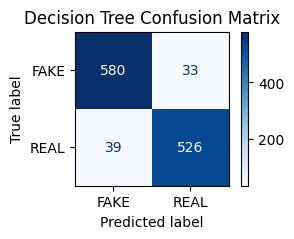

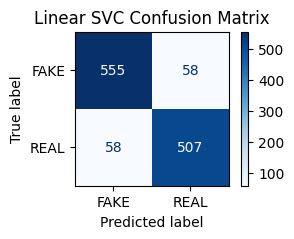

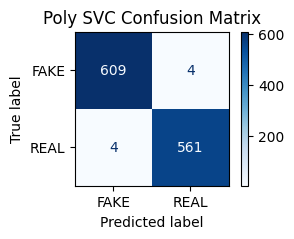

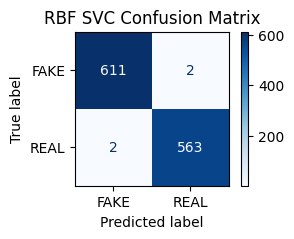

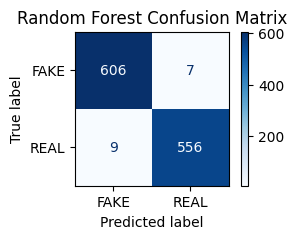

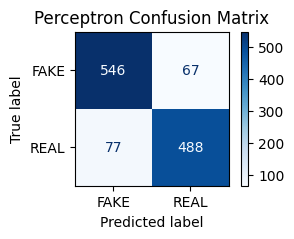

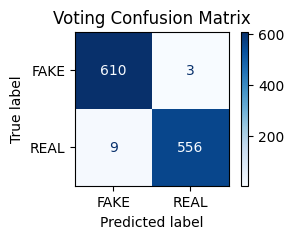

In [230]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

models = [tree_clf, linear_svc, svc_poly, svc_rbf, clf_rf_best, per_clf, voting_clf]
model_names = ['Decision Tree', 'Linear SVC', 'Poly SVC', 'RBF SVC', 'Random Forest', 'Perceptron', 'Voting']

# Get the names of the classes in the order that they are encoded
class_names = le_type.inverse_transform([0, 1])
print(class_names)
print("['0'   '1']")

for i, model in enumerate(models):
    # Predict the test data
    y_pred = model.predict(x_test)
    
    fig, ax = plt.subplots(figsize=(3, 2))
    
    # Calculate F1 score and store it in results_df
    f1 = f1_score(y_test, y_pred)
    results_df.loc[i, 'F1 Score'] = f1
    
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, ax=ax, cmap='Blues', display_labels=class_names)
    
    ax.set_title(f'{model_names[i]} Confusion Matrix')
    
    plt.show()

In [231]:
results_df = results_df.sort_values('Accuracy', ascending=False)
correlation_df = correlation_df.sort_index()

# fimportance_df = fimportance_df.sort_index()
# final_df_tree = fimportance_df.drop('Feature', axis=1)

fimportance_rf_df = fimportance_rf_df.sort_index()
final_df_forest= fimportance_rf_df.drop('Feature', axis=1)

final_df_forest
new_df = pd.concat([correlation_df, final_df_forest], axis=1)

new_df['Total score'] = new_df[['corr_score', 'Forest_imp_score']].sum(axis=1)
new_df = new_df.sort_values('Total score', ascending=False)
new_df

,Feature,Correlation,corr_score,Forest_imp,Forest_imp_score,Total score
7,mfcc2,0.36,25.0,0.089557,25.0,50.0
9,mfcc4,0.30,23.0,0.072202,24.0,47.0
23,mfcc18,0.35,24.0,0.062315,23.0,47.0
17,mfcc12,0.22,20.0,0.059873,21.0,41.0
14,mfcc9,0.24,21.0,0.059005,19.0,40.0
3,spectral_bandwidth,0.19,18.0,0.044458,18.0,36.0
11,mfcc6,0.28,22.0,0.037671,14.0,36.0
15,mfcc10,0.21,19.0,0.038626,15.0,34.0
13,mfcc8,0.14,12.0,0.061805,22.0,34.0
8,mfcc3,0.18,16.0,0.037131,13.0,29.0


In [232]:
results_df = results_df.sort_values('Accuracy', ascending=False)
results_df

,Model,Parameter,Accuracy,F1 Score
3,SVC rbf,"{'C': 10, 'gamma': 0.1}",0.996604,0.99646
2,SVC Poly,"{'C': 1, 'coef0': 0.5, 'degree': 4}",0.993209,0.99292
6,Ensemble,NaN,0.989813,0.989324
4,Random Forest,"n_est=64 {'bootstrap': False, 'max_features': ...",0.986418,0.985816
0,Decision Tree,NaN,0.938879,0.935943
1,Linear SVC,"C=1, loss=hinge",0.901528,0.897345
5,Perceptron,"{'max_iter': 5000, 'tol': 0.0001}",0.877759,0.871429


Feature reduction

In [233]:
# Get the names of the last 5 features in new_df
last_features = new_df['Feature'].tail(1)
#last_5_features
# Remove these features from df_std_enc
df_std_enc_red = df_std_enc.copy()
#Drop each feature one by one
for feature in last_features:
    if feature in df_std_enc_red.columns:
        df_std_enc_red = df_std_enc_red.drop(columns=feature)


#last_features
df_std_enc_red.info()
#df_std_enc_red

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11778 entries, 0 to 11777
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chroma_stft         11778 non-null  float64
 1   rms                 11778 non-null  float64
 2   spectral_centroid   11778 non-null  float64
 3   spectral_bandwidth  11778 non-null  float64
 4   rolloff             11778 non-null  float64
 5   zero_crossing_rate  11778 non-null  float64
 6   mfcc1               11778 non-null  float64
 7   mfcc2               11778 non-null  float64
 8   mfcc3               11778 non-null  float64
 9   mfcc4               11778 non-null  float64
 10  mfcc5               11778 non-null  float64
 11  mfcc6               11778 non-null  float64
 12  mfcc7               11778 non-null  float64
 13  mfcc8               11778 non-null  float64
 14  mfcc9               11778 non-null  float64
 15  mfcc10              11778 non-null  float64
 16  mfcc

In [234]:
# Data split    
x = df_std_enc_red.drop(columns='LABEL')
y = df_std_enc_red['LABEL']

test_ratio =0.1
train_ratio = 0.8/0.9
val_ratio = 0.1/0.9
rdm_val = 78

# Split the data into training+validation set and test set 
x_trval, x_test, y_trval, y_test = train_test_split(x, y, test_size=test_ratio, random_state=rdm_val)

# Split the training+validation set into training and validation sets 
x_train, x_val, y_train, y_val = train_test_split(x_trval, y_trval, test_size=val_ratio, random_state=rdm_val)

In [235]:
from sklearn.metrics import accuracy_score

results_df = results_df.sort_index()
# Assuming x_train and y_train are your training data and labels
# Assuming x_test and y_test are your test data and labels
for i, (model, name) in enumerate(zip(models, model_names)):
    # Retrain the model
    model.fit(x_train, y_train)
    
    # Predict the labels for the test data
    y_pred = model.predict(x_test)
    
    # Calculate the accuracy of the predictions
    accuracy = accuracy_score(y_test, y_pred)
    
    # Add the accuracy to a new column in results_df
    results_df.loc[i, 'Acc. post feat. red.'] = accuracy

# Get a list of all column names
cols = list(results_df.columns)

# Move the 'Acc. post feat. red.' column next to the 'Accuracy' column
cols.insert(cols.index('Accuracy') + 1, cols.pop(cols.index('Acc. post feat. red.')))

# Reindex the DataFrame with the new column order
results_df = results_df[cols]
results_df = results_df.sort_values('Accuracy', ascending=False)
results_df

,Model,Parameter,Accuracy,Acc. post feat. red.,F1 Score
3,SVC rbf,"{'C': 10, 'gamma': 0.1}",0.996604,0.996604,0.99646
2,SVC Poly,"{'C': 1, 'coef0': 0.5, 'degree': 4}",0.993209,0.993209,0.99292
6,Ensemble,NaN,0.989813,0.990662,0.989324
4,Random Forest,"n_est=64 {'bootstrap': False, 'max_features': ...",0.986418,0.988115,0.985816
0,Decision Tree,NaN,0.938879,0.943973,0.935943
1,Linear SVC,"C=1, loss=hinge",0.901528,0.903226,0.897345
5,Perceptron,"{'max_iter': 5000, 'tol': 0.0001}",0.877759,0.870119,0.871429


Results of feature reduction:
- Feature reduction does not improve the best accuracy nor significantly reduces it (tested up to last 10 features reduced)
- Could be interesting to reduce number of feature for speed performance (but not objective of the project)

## ML Challenges and limitations
### Identification of issues with the case:
1. Not enough variation of speakers.
2. Dataset not including phone call type quality audio (or other lower quality audio).
3. Uncertainty of chroma_stft value. 

### Identification of limitations with the case:
1. Not assessing other AI speech generation techniques other than RVC.
2. Detection speed not assessed. It is an important metric for real life application. 
3. Constant improvement of DeepFakes quality.

### Propose mitigation measures:
1. More speakers to further diversify the data and increase generalisation.
2. Further diversify the data with other AI speech generation approaches.
3. Delta mfcc and delta delta mfcc could provide additional information about the dynamics and rate of change of the spectral shape, which can be useful for the improvement of the classifiers accuracy.
4. Online/continuous learning algorithms + semi-supervised learning for adaptability to fake speech generation methods. (more realistic for real-life applications)

### Case conclusion summary:
**Objective** 
- Establish different prediction models for RVC-generated speech and rate their effectiveness. 
- 7 Different ML models were generated with the most effective being SVC using Radial Basis Function kernel with an accuracy of 99.66%.
<br> <br>

**Case question/answer** 
- Can we distinguish RVC-generated speeches from real speeches using machine learning? 
- Yes, for the dataset given. However, these results do not generalise for other low quality audios such as phone calls.
